In [48]:
import numpy as np
import pandas as pd
import scanpy as sc 

adata = sc.read_h5ad("GSE231467_Lung_Macrophage_Annotated.h5ad")
lr_genes = pd.read_csv("GSE231467_Lung_Macrophage_Annotated_xct_pairs.csv", header=0)  # Or header=True if you're on an older pandas version

In [49]:
# Extract source and receiver genes efficiently
gl_source = lr_genes.iloc[:2, 0].tolist()  # All values from the first column
gl_recv = lr_genes.iloc[:2, 1].tolist()    # All values from the second column

# Add CD68 as a *string*, not individual characters
#gl_source.append("CD68")  # Correct way to add a string
gl_recv.append("CD68")

# Convert to sets to get unique gene lists
gl_source = list(set(gl_source))  # Convert back to list if needed
gl_recv = list(set(gl_recv))

ict1 = adata.obs["celltype"] == "Macrophages"
ict2 = adata.obs["celltype"] == "LO" 
adata_ct1 = adata[ict1, gl_source]
adata_ct2 = adata[ict2, gl_recv]

In [50]:
print(adata_ct1)
print(adata_ct2)

View of AnnData object with n_obs × n_vars = 484 × 1
    obs: 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'leiden', 'celltype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 1990 × 3
    obs: 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'leiden', 'celltype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'celltype_colors', 'hvg', 'l

In [54]:
Xct1 = adata_ct1.layers["counts"].copy()
Xct2 = adata_ct2.layers["counts"].copy()
Xct1 = Xct1.toarray()
Xct2 = Xct2.toarray()

In [65]:

# Compute cell percentace of cell type 1 count matrix
Xct1p = np.sum(Xct1>0, axis=0)/len(Xct1[:,0])
Xct2p = np.sum(Xct2>0, axis=0)/len(Xct2[:,0])

print("CT1 Percentages:", Xct1p)
print("CT2 Percentages:", Xct2p)

CT1 Percentages: [0.98140496]
CT2 Percentages: [0.33969849 0.38341709 0.24572864]


In [66]:
# Scale the data from 0 to pi

ct1_percentages = (Xct1p-0.5) * np.pi 
ct2_percentages = (Xct2p-0.5) * np.pi

# Display the resulting scaled data
print("Scaled ct1_data:\n", ct1_percentages)
print("Scaled ct2_data:\n", ct2_percentages)

Scaled ct1_data:
 [1.51237828]
Scaled ct2_data:
 [-0.50360204 -0.36625603 -0.79881703]


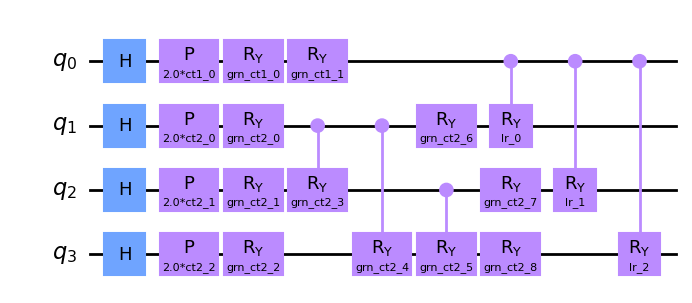

In [74]:
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZFeatureMap, TwoLocal
from qiskit.circuit import QuantumCircuit, Parameter

# --- 2. Quantum Circuit Setup ---
ng_ct1 = len(gl_source)
ng_ct2 = len(gl_recv)
num_features = ng_ct1 + ng_ct2

feature_map_ct1 = ZFeatureMap(feature_dimension=ng_ct1, reps=1)
feature_map_ct2 = ZFeatureMap(feature_dimension=ng_ct2, reps=1)

ansatz_grn_ct1 = TwoLocal(num_qubits=ng_ct1, rotation_blocks=['ry'], entanglement_blocks='cry', entanglement='full', reps=1)
ansatz_grn_ct2 = TwoLocal(num_qubits=ng_ct2, rotation_blocks=['ry'], entanglement_blocks='cry', entanglement='full', reps=1)
#ansatz_grn_ct1 = TwoLocal(num_qubits=ng_ct1, rotation_blocks=['ry', 'rz'], entanglement_blocks='cry', entanglement='full', reps=1)
#ansatz_grn_ct2 = TwoLocal(num_qubits=ng_ct2, rotation_blocks=['ry', 'rz'], entanglement_blocks='cry', entanglement='full', reps=1)

# Ligand-receptor interaction ansatz (across cell types)
def generate_inter_cell_pairs(ng_ct1, ng_ct2, direction="forward"):
    """Generates pairs of qubits for inter-cell interactions.
    Args:
        ng_ct1: Number of qubits in cell type 1.
        ng_ct2: Number of qubits in cell type 2.
        direction: "forward" for interactions from ct1 to ct2,
                   "backward" for interactions from ct2 to ct1,
    Returns:
        A list of qubit pairs.
    """
    pairs = []
    if direction == "forward":
        for i in range(ng_ct1):
            for j in range(ng_ct2):
                pairs.append([i, j + ng_ct1])
    elif direction == "backward":
        for i in range(ng_ct2):
            for j in range(ng_ct1):
                pairs.append([j + ng_ct2, i])

    else:
        raise ValueError("Invalid direction. Must be 'forward' or 'backward''.")
    return pairs

lr_entanglement = generate_inter_cell_pairs(ng_ct1, ng_ct2, direction="forward")  # Example: Entangle corresponding genes
#lr_entanglement = [[0, 2], [3, 1]]  # Example: Entangle corresponding genes
ansatz_lr = TwoLocal(num_qubits=num_features, entanglement_blocks='cry', entanglement=lr_entanglement, reps=1)

# Parameter Binding (Important!) - More concise way
def create_parameter_dict(circuit, prefix):
    return dict(zip(circuit.parameters, [Parameter(f"{prefix}_{i}") for i in range(circuit.num_parameters)]))

param_dict_ct1 = create_parameter_dict(feature_map_ct1, "ct1")
param_dict_ct2 = create_parameter_dict(feature_map_ct2, "ct2")
param_dict_grn_ct1 = create_parameter_dict(ansatz_grn_ct1, "grn_ct1")
param_dict_grn_ct2 = create_parameter_dict(ansatz_grn_ct2, "grn_ct2")
param_dict_lr = create_parameter_dict(ansatz_lr, "lr")

feature_map_ct1.assign_parameters(param_dict_ct1, inplace=True)
feature_map_ct2.assign_parameters(param_dict_ct2, inplace=True)
ansatz_grn_ct1.assign_parameters(param_dict_grn_ct1, inplace=True)
ansatz_grn_ct2.assign_parameters(param_dict_grn_ct2, inplace=True)
ansatz_lr.assign_parameters(param_dict_lr, inplace=True)

feature_map_ct1_decomposed = feature_map_ct1.decompose()
feature_map_ct2_decomposed = feature_map_ct2.decompose()
ansatz_grn_ct1_decomposed = ansatz_grn_ct1.decompose()
ansatz_grn_ct2_decomposed = ansatz_grn_ct2.decompose()
ansatz_lr_decomposed = ansatz_lr.decompose()

ccgrn_circuit = QuantumCircuit(num_features)

# Correctly append with appropriate qubit ranges
ccgrn_circuit.append(feature_map_ct1_decomposed, range(0, ng_ct1))
ccgrn_circuit.append(feature_map_ct2_decomposed, range(ng_ct1, num_features))
ccgrn_circuit.append(ansatz_grn_ct1_decomposed, range(0, ng_ct1))
ccgrn_circuit.append(ansatz_grn_ct2_decomposed, range(ng_ct1, num_features))
ccgrn_circuit.append(ansatz_lr_decomposed, range(num_features))


# Now you should see the individual gates when you draw the circuit
ccgrn_circuit.decompose().draw(output="mpl", style="clifford", fold=40)

In [ ]:
import pandas as pd
from scipy.optimize import minimize
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import StatevectorEstimator  # Or Estimator if using IBM Runtime

# Optimization section
# --- 3. Interaction Strength ---
interaction_strength_list = []
for pair in lr_entanglement:
    qubit1, qubit2 = pair
    pauli_string = ""
    for i in range(num_features):
        if i == qubit1 or i == qubit2:
            pauli_string += "Z"
        else:
            pauli_string += "I"
    interaction_strength_list.append((pauli_string, -1.0))
# Observable to measure the interaction strength (note: one link per pair, either forward or backward)
interaction_strength = SparsePauliOp.from_list(interaction_strength_list)

# Define cost function ONCE (outside the optimization loop)
def cost_func_vqe(params, combined_ansatz, hamiltonian, estimator):
    """Cost function for VQE (using StatevectorEstimator)"""
    bound_ansatz = combined_ansatz.assign_parameters(params)
    statevector = Statevector(bound_ansatz)  # Get the statevector
    statevector_array = statevector.data  # Convert Statevector to NumPy array

    # Correct way to calculate expectation value:
    hamiltonian_matrix = hamiltonian.to_matrix()
    energy = np.real(statevector_array.conjugate() @ hamiltonian_matrix @ statevector_array)  # Use @ operator
    #cost = estimator.run([pub]).result()[0].data.evs
    # or
    # energy = np.real(np.dot(statevector_array.conjugate(), np.dot(hamiltonian_matrix, statevector_array))) #Use numpy.dot
    return energy

def cost_func_wrapper(all_params_values, all_params, ccgrn_circuit, interaction_strength, estimator, variable_params): # Add all the arguments
    # Update the full parameter dictionary - Corrected
    for i, param in enumerate(variable_params):
        all_params[param] = all_params_values[i]
    return cost_func_vqe(all_params, ccgrn_circuit, interaction_strength, estimator)


In [ ]:
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize

estimator = StatevectorEstimator()

# --- Create the FULL parameter dictionary BEFORE optimization ---
def create_parameter_dictionaries(ccgrn_circuit, feature_map_ct1, feature_map_ct2, ct1_percentages, ct2_percentages):
    """Creates static and variable parameter dictionaries for cell percentages."""
    static_params = {}
    for i, val in enumerate(ct1_percentages):
        static_params[feature_map_ct1.parameters[i]] = val
    for i, val in enumerate(ct2_percentages):
        static_params[feature_map_ct2.parameters[i]] = val

    variable_params = [param for param in ccgrn_circuit.parameters if param not in static_params]
    return static_params, variable_params

static_params, variable_params = create_parameter_dictionaries(ccgrn_circuit, feature_map_ct1, feature_map_ct2, ct1_percentages, ct2_percentages)

# Initialize variable parameters
#x0_interaction = np.random.rand(len(variable_params))
x0_interaction = np.random.uniform(0, np.pi*2, len(variable_params))

# Create initial full parameter dictionary - THIS IS THE KEY CHANGE
all_params = static_params.copy()  # Start with static parameters
all_params.update(dict(zip(variable_params, x0_interaction)))  # Add variable parameters


In [78]:
# Call minimize with args
result_interaction_bfgs = minimize(
    cost_func_wrapper,
    x0_interaction,
    args=(all_params, ccgrn_circuit, interaction_strength, estimator, variable_params), # Pass all the arguments as a tuple
    method="BFGS"
)
print(result_interaction_bfgs)

# --- 6. Results and DataFrame ---
optimized_variable_parameters = result_interaction_bfgs.x

# Update the full parameter dictionary with optimized variable parameters
for param, value in zip(variable_params, optimized_variable_parameters):
    all_params[param] = value

df = pd.DataFrame(list(all_params.items()), columns=['Parameter', 'Value'])
df_nonzero = df[abs(df.Value) >= 0.01]
print(df_nonzero)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.06102147178908712
        x: [ 4.401e+00  3.111e-01 ...  6.413e+00  6.127e+00]
      nit: 97
      jac: [-1.043e-07 -1.192e-07 ...  3.785e-06 -2.235e-06]
 hess_inv: [[ 1.621e+01  1.523e+01 ...  2.112e+01 -1.342e+01]
            [ 1.523e+01  1.626e+01 ...  2.874e+01 -1.242e+01]
            ...
            [ 2.112e+01  2.874e+01 ...  1.063e+04  4.273e+03]
            [-1.342e+01 -1.242e+01 ...  4.273e+03  6.452e+03]]
     nfev: 1515
     njev: 101
    Parameter     Value
0       ct1_0  1.512378
1       ct2_0 -0.503602
2       ct2_1 -0.366256
3       ct2_2 -0.798817
4   grn_ct1_0  4.401259
5   grn_ct1_1  0.311123
6   grn_ct2_0  4.712480
7   grn_ct2_1  1.156278
8   grn_ct2_2  5.972208
9   grn_ct2_3  3.141394
10  grn_ct2_4  3.136525
12  grn_ct2_6  3.364534
13  grn_ct2_7  0.285428
14  grn_ct2_8  5.181404
15       lr_0  6.058908
16       lr_1  6.412510
17       lr_2  6.126768


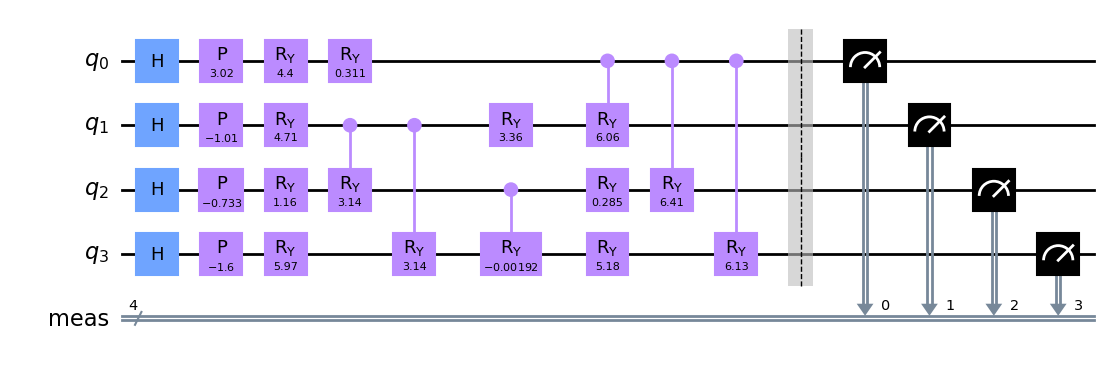

In [79]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
#from qiskit.primitives import SamplerV2  as Sampler  # Import Sampler
#from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Use AerSimulator
sampler = StatevectorSampler()
# Bind the optimized parameters to the circuit
bound_circuit = ccgrn_circuit.copy()
bound_circuit.assign_parameters(all_params, inplace=True)
bound_circuit.measure_all() # Add measurement to all the qubits
bound_circuit.decompose().draw(output="mpl", style="clifford", fold=40)

In [46]:
print(gl_source)
print(gl_recv)

['SPP1']
['CD68', 'ITGA2', 'PLAU']


The number of bitstrings is: 1024
The counts are: {'1111': 368, '0111': 308, '1011': 52, '0001': 102, '0101': 15, '1001': 107, '0011': 53, '1101': 15, '0110': 2, '1110': 2}


C:\Users\ssromerogon\AppData\Local\Temp\ipykernel_77832\2759918554.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts, title="Quantum Sampler Results").show()


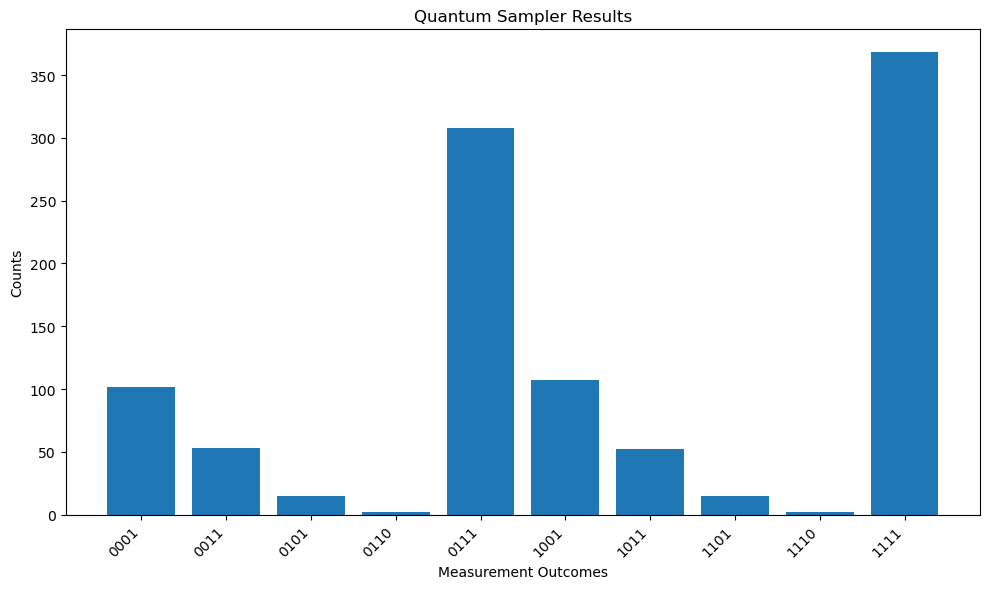

{'1111': 368, '0111': 308, '1011': 52, '0001': 102, '0101': 15, '1001': 107, '0011': 53, '1101': 15, '0110': 2, '1110': 2}


In [80]:
# Run the quantum sampler
job = sampler.run( [bound_circuit], shots=1024 )  # Adjust shots as needed
pub_result = job.result()[0]
data_pub = pub_result.data
# Access bitstring for the classical register "meas"
bitstrings = data_pub.meas.get_bitstrings()
print(f"The number of bitstrings is: {len(bitstrings)}")
# Get counts for the classical register "meas"
counts = data_pub.meas.get_counts()
print(f"The counts are: {counts}")

# Plot the histogram
plot_histogram(counts, title="Quantum Sampler Results").show()

# If you want to use matplotlib directly for more customization
# Convert counts to list for plotting
sorted_counts = dict(sorted(counts.items()))
x_labels = list(sorted_counts.keys())
y_values = list(sorted_counts.values())

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(x_labels, y_values)
plt.xlabel("Measurement Outcomes")
plt.ylabel("Counts")
plt.title("Quantum Sampler Results")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Print the counts
print(counts)
